<a href="https://colab.research.google.com/github/danieldalton13/optimisation_top_Y1/blob/main/joints_residuals_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometry Check

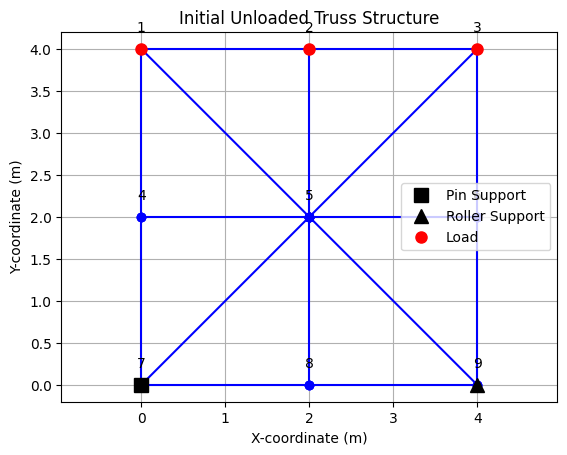

In [1]:
import matplotlib.pyplot as plt

# Define node coordinates
nodes = {
    1: (0, 4),
    2: (2, 4),
    3: (4, 4),
    4: (0, 2),
    5: (2, 2),
    6: (4, 2),
    7: (0, 0),
    8: (2, 0),
    9: (4, 0)
}

# Define members as pairs of nodes
members = [
    (1, 2), (2, 3),
    (4, 5), (5, 6),
    (7, 8), (8, 9),
    (1, 4), (4, 7),
    (2, 5), (5, 8),
    (3, 6), (6, 9),
    (1, 5), (3, 5), (5, 7), (5, 9)
]

# Plot each member
for member in members:
    x_values = [nodes[member[0]][0], nodes[member[1]][0]]
    y_values = [nodes[member[0]][1], nodes[member[1]][1]]
    plt.plot(x_values, y_values, 'b-o')  # Blue lines with circle markers

# Highlight supports
plt.plot(nodes[7][0], nodes[7][1], 'ks', markersize=10, label='Pin Support')   # Square for pin
plt.plot(nodes[9][0], nodes[9][1], 'k^', markersize=10, label='Roller Support')  # Triangle for roller

# Highlight loaded nodes
plt.plot(nodes[1][0], nodes[1][1], 'ro', markersize=8, label='Load')  # Red circles for loads
plt.plot(nodes[2][0], nodes[2][1], 'ro', markersize=8)
plt.plot(nodes[3][0], nodes[3][1], 'ro', markersize=8)

# Annotate nodes
for node, (x, y) in nodes.items():
    plt.text(x, y + 0.2, str(node), ha='center')

plt.title('Initial Unloaded Truss Structure')
plt.xlabel('X-coordinate (m)')
plt.ylabel('Y-coordinate (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# Optimisation Algorithm - Fixed Member Force (3 by 3)

This function computes the residuals (differences) for the equilibrium equations of the truss. The goal is to find values for the internal forces of members and the coordinates `(x, y)` of Node 5 such that all equilibrium conditions (sum of forces in X and Y directions) are satisfied at every node.

**Variables**
* `variables`: A list containing the unknowns:
    * Member Forces: `F12, F23, F45, F56, F78, F89, F14, F47, F25, F58, F36, F69, F35, F57, F59`
    * Coordinates of Node 5: `x, y`

* `F15`: A fixed number force set to `-4.0kN` (compression).

**Truess Equilibrium Residuals Function (`truss_equilibrium_residuals`)**
1. Unpack the variaiables:
    * The list `variables` is unpacked into individual member forces and the coordinates `(x, y)` of Node 5.
2. Update Node 5 Coordinates:
    * The position of Node 5 is updated in the `nodes` dictionary with the current values of `x` and `y`.
3. Define Support Reactions:
    * Node 7: Pin support with reactions `Rx7 = 0.0 kN` and `Ry7 = 15.0kN` upward.
    * Node 9: Roller support with reactions `Rx9 = 0.0 kN` and `Ry9 = 15.0 kN` upward.
    * Reactions are assumed and inputted based upon the problem setup.
4. Create Member Forces Dictionary:
    * Combines all member forces, including the fixed force `F15`, into a dictionary for easy access.
5. Define Direction Cosines Function:
    * `direction_cosines(start, end)`: Computes the cosine of the angle `(cx)` and sine of the angle `(cy)` for a member connecting `start` and `end` nodes.
    * Angles used to resolve the member forces into their horizontal `(Fx)` and vertical `(Fy)` components.
6. Iterate through each node (1 to 9):
    * Initialise `sum_fx` and `sum_fy` to zero for each node.
    * Iterate through all members:
      * Check if the current node is connected to the member:
        * If the node is the start node of the member:
          * The force acts away from the node (tension).
          * Add the force's hroizontal and vertical components to `sum_fx` and `sum_fy`.
        * If the node is the end node of the member:
          * The force acts towards the node (compression).
          * Subtract the force' horizontal and vertical components from `sum_fx` and `sum_fy`.
    * Apply external loads:
      * Nodes 1, 2, 3: Each has a downward load of `10kN`.
      * Effect: subtract `10kN` from `sum_fy` for these nodes.
    * Apply support reactions:
      * Node 7: Add `Rx7` to `sum_fx` and `Ry7` to `sum_fy`.
      * Node 9: Add `Rx9` to `sum_fx` and `Ry9` to `sum_fy`.
    * Append residuals:
      * Sum of Forces in X (`sum_fx`) - should be zero for equilibrium.
      * Sum of Forces in Y (`sum_fy`) - should be zero for equilibrium.
7. Return residuals:
  * Function returns a list of residuals for all the equilibrium equations (18 in total: 2 for each of the 9 nodes).

**An initial guess is made for variables** - provides an initial guess for the optimization algorithm - components: member forces (assumed starting values) and coordinates of node 5 (initially set to (2.0, 2.0) meters.

**Solving the equilibrium equations**
    * `least_squares` - a function from SciPy's optimisation library that minimises the sum of squares of residuals.
    * Parameters:
      * `truss_equilibrium_residuals`: The function to compute residuals.
      * `initial_guess`: Starting point for the variables.
      * `ftol=1e-9`, `xtol=1e-9`: Tolerance levels for the termination of the algorithm.
      * `verbose=2`: Enables detailed output during the optimisation process, showing the progress of iterations.


**Residuals and Optimiser Example**

Equilibrium Conditions:

$ F_{1}.cos(\theta_{1}) + F_{2}.cos(\theta_2) = 0$

$ F_{1}.sin(\theta_{1}) + F_{2}.sin(\theta_2) - 10 = 0$

Residuals:

$ R_{1} = F_{1}.cos(\theta_{1}) + F_{2}.cos(\theta_2)$

$ R_{2} = F_{1}.sin(\theta_{1}) + F_{2}.sin(\theta_2) - 10$

The optimiser adjusts $F_1$ and $F_2$ to minimise $R_1$ and $R_2$ towards zero.


In [2]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Define the nodes with their initial coordinates
nodes = {
    1: (0.0, 4.0),
    2: (2.0, 4.0),
    3: (4.0, 4.0),
    4: (0.0, 2.0),
    5: (None, None),  # To be determined (x, y)
    6: (4.0, 2.0),
    7: (0.0, 0.0),
    8: (2.0, 0.0),
    9: (4.0, 0.0)
}

# Define the members as a list of tuples: (Member Name, Start Node, End Node)
members = [
    ('F12', 1, 2),
    ('F23', 2, 3),
    ('F45', 4, 5),
    ('F56', 5, 6),
    ('F78', 7, 8),
    ('F89', 8, 9),
    ('F14', 1, 4),
    ('F47', 4, 7),
    ('F25', 2, 5),
    ('F58', 5, 8),
    ('F36', 3, 6),
    ('F69', 6, 9),
    ('F35', 3, 5),
    ('F57', 5, 7),
    ('F59', 5, 9)
]

def truss_equilibrium_residuals(variables):
    """
    Calculates residuals for the truss equilibrium equations.
    variables: [F12, F23, F45, F56, F78, F89,
               F14, F47, F25, F58, F36, F69,
               F35, F57, F59, x, y]
    Returns a list of 18 residuals corresponding to the equilibrium equations.
    """
    # Unpack variables
    F12, F23, F45, F56, F78, F89, F14, F47, F25, F58, F36, F69, F35, F57, F59, x, y = variables

    # Fixed member force
    F15 = -4.0  # kN (compression)

    # Update node 5's coordinates
    nodes[5] = (x, y)

    # Reactions at supports (known)
    Rx7 = 0.0  # kN
    Ry7 = 15.0  # kN upward
    Rx9 = 0.0  # kN
    Ry9 = 15.0  # kN upward

    # Member forces dictionary
    member_forces = {
        'F12': F12,
        'F23': F23,
        'F45': F45,
        'F56': F56,
        'F78': F78,
        'F89': F89,
        'F14': F14,
        'F47': F47,
        'F25': F25,
        'F58': F58,
        'F36': F36,
        'F69': F69,
        'F35': F35,
        'F57': F57,
        'F59': F59,
        'F15': F15  # Fixed member
    }

    # Initialize residuals list
    residuals = []

    # Function to calculate direction cosines
    def direction_cosines(start, end):
        xi, yi = nodes[start]
        xj, yj = nodes[end]
        dx = xj - xi
        dy = yj - yi
        L = np.sqrt(dx**2 + dy**2)
        if L == 0:
            return 0.0, 0.0
        return dx / L, dy / L

    # Iterate through each node and apply equilibrium
    for node in range(1, 10):  # Nodes 1 through 9
        sum_fx = 0.0
        sum_fy = 0.0

        # Iterate through all members to find those connected to the current node
        for member in members:
            name, start, end = member
            force = member_forces[name]
            cx, cy = direction_cosines(start, end)

            if node == start:
                # Force acts away from the node (tension)
                sum_fx += force * cx
                sum_fy += force * cy
            elif node == end:
                # Force acts towards the node (compression)
                sum_fx -= force * cx
                sum_fy -= force * cy
            # If the member is not connected to the current node, do nothing

        # Apply external loads
        if node in [1, 2, 3]:
            sum_fy -= 10.0  # 10 kN downward load

        # Apply support reactions
        if node == 7:
            # Node 7 has reactions Rx7 and Ry7
            sum_fx += Rx7
            sum_fy += Ry7
        if node == 9:
            # Node 9 has reactions Rx9 and Ry9
            sum_fx += Rx9
            sum_fy += Ry9

        # Append equilibrium equations
        residuals.append(sum_fx)  # Sum of Fx = 0
        residuals.append(sum_fy)  # Sum of Fy = 0

    # No need to add a separate equation for F15 since it's fixed and included in member_forces

    return residuals

# Initial guess for variables:
# [F12, F23, F45, F56, F78, F89,
#  F14, F47, F25, F58, F36, F69,
#  F35, F57, F59, x, y]

initial_guess = [
    10.0,  # F12
    10.0,  # F23
    10.0,  # F45
    10.0,  # F56
    15.0,  # F78
    15.0,  # F89
    10.0,  # F14
    15.0,  # F47
    10.0,  # F25
    10.0,  # F58
    10.0,  # F36
    15.0,  # F69
    10.0,  # F35
    10.0,  # F57
    10.0,  # F59
    2.0,   # x
    2.0    # y
]

# Solve the system using least_squares
result = least_squares(truss_equilibrium_residuals, initial_guess, ftol=1e-9, xtol=1e-9, verbose=2)

# Check if the solution was successful
if result.success:
    solution = result.x
    F12, F23, F45, F56, F78, F89, F14, F47, F25, F58, F36, F69, F35, F57, F59, x, y = solution

    # Fixed member force
    F15 = -4.0  # kN

    # Print the results
    print("\nSolution Found:")
    print(f"F12 (Member 1-2): {F12:.2f} kN")
    print(f"F23 (Member 2-3): {F23:.2f} kN")
    print(f"F45 (Member 4-5): {F45:.2f} kN")
    print(f"F56 (Member 5-6): {F56:.2f} kN")
    print(f"F78 (Member 7-8): {F78:.2f} kN")
    print(f"F89 (Member 8-9): {F89:.2f} kN")
    print(f"F14 (Member 1-4): {F14:.2f} kN")
    print(f"F47 (Member 4-7): {F47:.2f} kN")
    print(f"F25 (Member 2-5): {F25:.2f} kN")
    print(f"F58 (Member 5-8): {F58:.2f} kN")
    print(f"F36 (Member 3-6): {F36:.2f} kN")
    print(f"F69 (Member 6-9): {F69:.2f} kN")
    print(f"F35 (Member 3-5): {F35:.2f} kN")
    print(f"F57 (Member 5-7): {F57:.2f} kN")
    print(f"F59 (Member 5-9): {F59:.2f} kN")
    print(f"F15 (Member 1-5): {F15:.2f} kN (Fixed)")
    print(f"Position of Node 5: x = {x:.2f} m, y = {y:.2f} m")
else:
    print("Solution did not converge.")
    print(result.message)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0485e+03                                    1.06e+02    
       1              2         2.0201e+02      2.85e+03       4.48e+01       1.33e+01    
       2              4         1.0589e+02      9.61e+01       4.36e+00       8.56e+00    
       3              5         1.1992e+01      9.39e+01       8.73e+00       7.72e+00    
       4              6         2.8663e-03      1.20e+01       6.87e+00       2.15e-01    
       5              7         2.0781e-08      2.87e-03       9.60e-02       1.16e-03    
       6              8         1.2435e-18      2.08e-08       2.06e-04       6.70e-09    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.0485e+03, final cost 1.2435e-18, first-order optimality 6.70e-09.

Solution Found:
F12 (Member 1-2): -0.00 kN
F23 (Member 2-3): 3.15 kN
F45 (Member 4-5): 0.00 kN
F56 (Member 5-6): -0.00 kN
F

# Verification

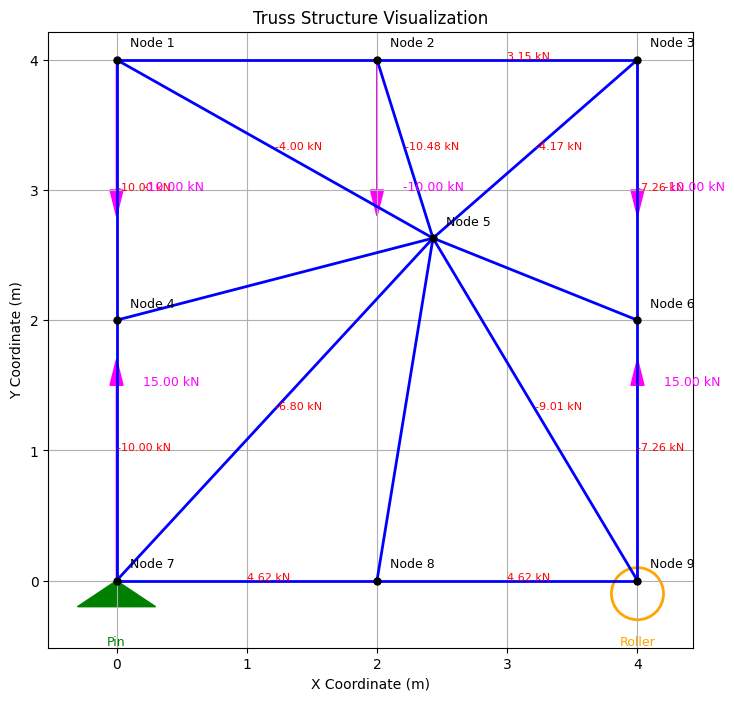

----- Equilibrium Check -----
Sum of Horizontal Internal Forces (ΣFx): 8.91 kN
Sum of Vertical Internal Forces (ΣFy): 61.96 kN
Sum of External Horizontal Loads (ΣFx_external): 0.00 kN
Sum of External Vertical Loads (ΣFy_external): 0.00 kN

Support Reactions:
Horizontal Reaction at Pin (Node 1), Rx1: -8.91 kN
Vertical Reactions:
  At Pin (Node 1), Ry1: To be determined
  At Roller (Node 3), Ry3: To be determined
Total Vertical Reaction, Ry1 + Ry3: -61.96 kN

Calculated Support Reactions:
  At Pin (Node 1), Rx1: -8.91 kN
  At Pin (Node 1), Ry1: -31.63 kN
  At Roller (Node 3), Ry3: -30.33 kN

The truss structure is in equilibrium.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Define Nodes
# ------------------------------

nodes = {
    7: (0, 0),
    8: (2, 0),
    9: (4, 0),
    4: (0, 2),
    5: (2.43, 2.63),
    6: (4, 2),
    1: (0, 4),
    2: (2, 4),
    3: (4, 4)
}

# ------------------------------
# Define Members
# ------------------------------
# Each member is a tuple of node numbers
members = [
    (1, 2), (2, 3), (4, 5), (5, 6), (7, 8),
    (8, 9), (1, 4), (4, 7), (2, 5), (5, 8),
    (3, 6), (6, 9), (3, 5), (5, 7), (5, 9),
    (1, 5)
]

# ------------------------------
# Define Member Forces (in kN)
# ------------------------------
# Positive force indicates tension; negative indicates compression
member_forces = {
    (1, 2): -0.00,
    (2, 3): 3.15,
    (4, 5): 0.00,
    (5, 6): -0.00,
    (7, 8): 4.62,
    (8, 9): 4.62,
    (1, 4): -10.00,
    (4, 7): -10.00,
    (2, 5): -10.48,
    (5, 8): -0.00,
    (3, 6): -7.26,
    (6, 9): -7.26,
    (3, 5): -4.17,
    (5, 7): -6.80,
    (5, 9): -9.01,
    (1, 5): -4.00
}

# ------------------------------
# Define Supports
# ------------------------------
# Assuming:
# Node 7: Pin Support (both Fx and Fy)
# Node 9: Roller Support (only Fy)

supports = {
    7: {'type': 'pin'},
    9: {'type': 'roller'}
}

# ------------------------------
# Define External Loads
# ------------------------------
# 10 kN downward applied to the top three nodes: 1, 2, 3
external_loads = {
    1: (0, -10),  # Divided equally among nodes 1, 2, 3
    2: (0, -10),
    3: (0, -10),
    7: (0, 15),
    9: (0, 15)
}

# ------------------------------
# Plotting the Truss
# ------------------------------
def plot_truss(nodes, members, member_forces, supports, external_loads):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot members
    for member in members:
        start, end = member
        x_values = [nodes[start][0], nodes[end][0]]
        y_values = [nodes[start][1], nodes[end][1]]
        ax.plot(x_values, y_values, 'b-', linewidth=2)

        # Calculate midpoint for force annotation
        mid_x = (nodes[start][0] + nodes[end][0]) / 2
        mid_y = (nodes[start][1] + nodes[end][1]) / 2

        # Annotate member forces
        force = member_forces.get(member, member_forces.get((member[1], member[0]), 0))
        if force != 0:
            ax.text(mid_x, mid_y, f'{force:.2f} kN', color='red', fontsize=8)

    # Plot nodes
    for node, (x, y) in nodes.items():
        ax.plot(x, y, 'ko', markersize=5)
        ax.text(x + 0.1, y + 0.1, f'Node {node}', fontsize=9)

    # Plot supports
    for node, support in supports.items():
        x, y = nodes[node]
        if support['type'] == 'pin':
            # Draw a triangle for pin support
            triangle = plt.Polygon([[x-0.3, y-0.2], [x+0.3, y-0.2], [x, y]], closed=True, color='green')
            ax.add_patch(triangle)
            ax.text(x, y-0.5, 'Pin', color='green', fontsize=9, ha='center')
        elif support['type'] == 'roller':
            # Draw a circle for roller support
            circle = plt.Circle((x, y-0.1), 0.2, color='orange', fill=False, linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y-0.5, 'Roller', color='orange', fontsize=9, ha='center')

    # Plot external loads
    for node, (fx, fy) in external_loads.items():
        x, y = nodes[node]
        if fy != 0:
            # Draw downward arrow for vertical loads
            ax.arrow(x, y, 0, fy*0.1, head_width=0.1, head_length=0.2, fc='magenta', ec='magenta')
            ax.text(x + 0.2, y + fy*0.1, f'{fy:.2f} kN', color='magenta', fontsize=9)

    ax.set_xlabel('X Coordinate (m)')
    ax.set_ylabel('Y Coordinate (m)')
    ax.set_title('Truss Structure Visualization')
    ax.grid(True)
    ax.set_aspect('equal', 'box')
    plt.show()

# ------------------------------
# Equilibrium Check
# ------------------------------
def equilibrium_check(nodes, members, member_forces, supports, external_loads):
    # Initialize sums
    sum_fx = 0
    sum_fy = 0

    # Sum member forces
    for member in members:
        start, end = member
        force = member_forces.get(member, member_forces.get((end, start), 0))

        # Direction vector from start to end
        dx = nodes[end][0] - nodes[start][0]
        dy = nodes[end][1] - nodes[start][1]
        length = np.hypot(dx, dy)
        cos_theta = dx / length if length != 0 else 0
        sin_theta = dy / length if length != 0 else 0

        # Determine direction based on member orientation
        fx = force * cos_theta
        fy = force * sin_theta

        # If the force is from end to start, reverse the direction
        if (end, start) in member_forces:
            fx = -fx
            fy = -fy

        sum_fx += fx
        sum_fy += fy

    # Sum external loads
    total_external_fx = 0
    total_external_fy = 0
    for load in external_loads.values():
        total_external_fx += load[0]
        total_external_fy += load[1]

    # Support reactions
    # Assuming horizontal reactions only at pin (node 1)
    # and vertical reactions at both pin (node 1) and roller (node 3)
    # Let Rx1 and Ry1 be reactions at pin (node 1)
    # Let Ry3 be reaction at roller (node 3)
    # From global equilibrium:
    # ΣFx = Rx1 = -sum_fx + total_external_fx
    # ΣFy = Ry1 + Ry3 = -sum_fy + total_external_fy

    # Calculate reactions
    Rx1 = -sum_fx + total_external_fx
    Ry_total = -sum_fy + total_external_fy

    # Display results
    print("----- Equilibrium Check -----")
    print(f"Sum of Horizontal Internal Forces (ΣFx): {sum_fx:.2f} kN")
    print(f"Sum of Vertical Internal Forces (ΣFy): {sum_fy:.2f} kN")
    print(f"Sum of External Horizontal Loads (ΣFx_external): {total_external_fx:.2f} kN")
    print(f"Sum of External Vertical Loads (ΣFy_external): {total_external_fy:.2f} kN\n")

    print("Support Reactions:")
    print(f"Horizontal Reaction at Pin (Node 1), Rx1: {Rx1:.2f} kN")
    print(f"Vertical Reactions:")
    print(f"  At Pin (Node 1), Ry1: To be determined")
    print(f"  At Roller (Node 3), Ry3: To be determined")
    print(f"Total Vertical Reaction, Ry1 + Ry3: {Ry_total:.2f} kN")

    # To solve for Ry1 and Ry3, use moment equilibrium about one support
    # Let's take moment about node 1 to solve for Ry3

    # Calculate moments due to external loads and internal forces about node 1
    moment_external = 0
    for node, (fx, fy) in external_loads.items():
        x, y = nodes[node]
        moment_external += x * fy  # Clockwise positive

    # Calculate moments due to member forces about node 1
    moment_members = 0
    for member in members:
        start, end = member
        force = member_forces.get(member, member_forces.get((end, start), 0))
        # Position of force application: assume it's at the start node
        x, y = nodes[start]
        dx = nodes[end][0] - x
        dy = nodes[end][1] - y
        length = np.hypot(dx, dy)
        if length == 0:
            continue
        cos_theta = dx / length
        sin_theta = dy / length
        # Force components
        fx = force * cos_theta
        fy = force * sin_theta
        # Moment arm
        moment = x * fy - y * fx  # z-component
        moment_members += moment

    # Total moment about node 1
    total_moment = moment_external + moment_members

    # Moment due to Ry3 at roller (node 3)
    x3, y3 = nodes[3]
    moment_Ry3 = x3 * Ry_total  # Ry1 does not create moment about node 1

    # Equilibrium: total_moment + moment_Ry3 = 0
    # Solve for Ry3
    Ry3 = -total_moment / x3 if x3 != 0 else 0
    Ry1 = Ry_total - Ry3

    print("\nCalculated Support Reactions:")
    print(f"  At Pin (Node 1), Rx1: {Rx1:.2f} kN")
    print(f"  At Pin (Node 1), Ry1: {Ry1:.2f} kN")
    print(f"  At Roller (Node 3), Ry3: {Ry3:.2f} kN")

    # Check equilibrium
    equilibrium = np.isclose(sum_fx + Rx1, 0, atol=1e-2) and np.isclose(sum_fy + Ry_total, 0, atol=1e-2)
    if equilibrium:
        print("\nThe truss structure is in equilibrium.")
    else:
        print("\nThe truss structure is NOT in equilibrium.")

# ------------------------------
# Run the Functions
# ------------------------------
if __name__ == "__main__":
    plot_truss(nodes, members, member_forces, supports, external_loads)
    equilibrium_check(nodes, members, member_forces, supports, external_loads)